# Predicting Salaries for Software Developers in the United States

## Introduction

With the Bureau Labor of Statistic (BLS) projecting that employment in the software development field **will grow about 26%** by 2031, understanding compensation trends is crucial for talent acquisition and individual career development.

## Business Problem

1. What are the factors influencing software developer salaies in the U.S?
2. How effectively can these factors be in predicting software developers' salary in the US?

## Dataset

**2023 Stack Overflow Developer Survey**: Comprehensive dataset that includes responses from a wide range of participants in multiple countries, with information such as coding experience, programming languages and software expertise, job role and many others.


# Imports

In [1]:
#Data Manipulation and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
import scipy.stats as stats
from tabulate import tabulate
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import pearsonr

#### Load Data

In [2]:
# Load the data to a dataframe
file = 'stack_overflow_survey_developers_2023.csv'
df = pd.read_csv(file, encoding='utf-8')

# Make sure it was loaded correctly
print(f"Rows: {df.shape[0]} | Cols: {df.shape[1]}")
df.head(2)

Rows: 89184 | Cols: 84


,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0


# Preliminary EDA & Cleaning
- This section aims to perform initial exploration and cleaning to tailor the dataset for only Developers in the U.S and understand the dataset's structure.

In [3]:
#Rename columns for clarity and consistency
df.rename(columns={
    'MainBranch': 'CodingRole',   #Specifying that 'MainBranch' refers to the coding role
    'Employment': 'EmploymentStatus', #Specifying that 'Employment' refers to the current employment status (full-time, part-time)
    'RemoteWork': 'WorkSetting', #Specifying that 'RemoteWork' refers to the current Work Setting of the respondant (On-site, remote, hybrid)
    'YearsCode': 'YearsCodeExp', #Specifying that 'YearsCode' refers to the total years of coding experience
    'YearsCodePro': 'YearsCodeProExp', #Specifying that 'YearsCodePro' refers to the total years of Professional coding experience
    'WorkExp': 'YearsWorkExp', #Specifying that 'WorkExp' refers to the total years of Work experience
    'DevType': 'JobRole'  #Specifying that 'DevType' refers to current Job role of the respondant
}, inplace=True)

df['WorkSetting'] = df['WorkSetting'].replace('Hybrid (some remote, some in-person)', 'Hybrid')

In [4]:
# Checking the DataFrame information to assess data types and non-null counts
df_info = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   CodingRole                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   EmploymentStatus                     87898 non-null  object 
 5   WorkSetting                          73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCodeExp                

In [5]:
#The DataFrame consists of 89,184 entries across 84 columns. It includes a mix of data types: 3 floats, 1 int, and 80 object types. 

In [6]:
# Calculate and display the total and percentage of null values per column
nulls_tab = pd.concat([
    df.isnull().sum().rename('Total'), 
    df.isnull().mean().rename('Percent').mul(100)
], axis=1).sort_values(by='Total', ascending=False).head(15)

nulls_tab

,Total,Percent
AINextVery similar,86563,97.061132
AINextSomewhat similar,82946,93.005472
AINextNeither different nor similar,82585,92.600691
AINextVery different,76523,85.803507
AIDevWantToWorkWith,69597,78.037540
AIToolNot interested in Using,68115,76.375807
AINextSomewhat different,65881,73.870874
AIDevHaveWorkedWith,63280,70.954431
AIToolInterested in Using,56401,63.241164
AIToolCurrently Using,53047,59.480400


In [7]:
# Generating descriptive statistics to get an overview of the numerical features
df.describe()

,ResponseId,CompTotal,YearsWorkExp,ConvertedCompYearly
count,89184.000000,4.822500e+04,43579.000000,4.801900e+04
mean,44592.500000,1.036807e+42,11.405126,1.031101e+05
std,25745.347541,2.276847e+44,9.051989,6.814188e+05
min,1.000000,0.000000e+00,0.000000,1.000000e+00
25%,22296.750000,6.300000e+04,5.000000,4.390700e+04
50%,44592.500000,1.150000e+05,9.000000,7.496300e+04
75%,66888.250000,2.300000e+05,16.000000,1.216410e+05
max,89184.000000,5.000000e+46,50.000000,7.435143e+07


CompTotal: The total compensation has a very wide range, with a minimum of 0 and a maximum that is extremely high, suggesting outliers or data entry errors. The mean is significantly higher than the median, which further indicates a right-skewed distribution and the presence of extreme values. In addition, The standard deviation for 'CompTotal'  is very large, again indicating a wide dispersion

## Preliminary Cleaning

Before diving into analysis, we must address several preprocessing needs, particularly encoding categorical variables and handling the numerous null values present in our dataset.

To facilitate exploration, a subset of columns will be selected for this project:

- `CodingRole`
- `Age`
- `EmploymentStatus`
- `WorkSetting`
- `EdLevel`
- `YearsCodeExp`
- `YearsCodeProExp`
- `YearsWorkExp`
- `JobRole`
- `OrgSize`
- `Country`
- `Currency`
- `CompTotal`
- `LanguageHaveWorkedWith`
- `DatabaseHaveWorkedWith`
- `PlatformHaveWorkedWith`
- `ProfessionalTech`
- `Industry`

The preliminary cleaning process will include the following steps:

1. **Filtering for Full-Time Developers in the U.S.**
2. **Converting Age Ranges to Midpoints:** Translating categorical age ranges to numerical midpoints for a more precise age representation.
3. **Imputing Missing Values in 'YearsCodeExp':** If 'YearsCodeExp' is null and 'YearsCodeProExp' is not, the former will be filled with values from the latter.
4. **Transforming 'Coding Work Experience' to Numeric Values:** Converting textual data to a numerical format for analysis.
5. **Restricting 'CompTotal' to Realistic Ranges:** Only including total compensation between \\$60,000 and \\$400,000 to align with industry standards.
6. **Categorizing Job Roles:** Grouping into broader categories such as 'Developer', 'Manager', 'Academia', etc.
7. **Standardizing 'Industry' Values:** Filling missing industry data with the most common industry in the dataset.
8. **Numerical Conversion of 'OrgSize':** Applying a midpoint value approach to size ranges and filling missing values with the mode (10,000).

Each step will bring us closer to a refined dataset ready for in-depth analysis.

In [8]:
# The dataset contains various data types and missing values, requiring preprocessing before analysis.
# A subset of relevant columns is selected to facilitate data exploration.

selected_columns = [
    'CodingRole', 'Age', 'EmploymentStatus', 'WorkSetting', 'EdLevel',
    'YearsCodeExp', 'YearsCodeProExp', 'YearsWorkExp', 'JobRole',
    'OrgSize', 'Country', 'Currency', 'CompTotal', 'LanguageHaveWorkedWith',
    'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'ProfessionalTech',
    'Industry'
]

# Selecting relevant columns for analysis
df = df[selected_columns]
df.shape

(89184, 18)

## Full-Time Developers
- Keep only Full-Time Developers within the U.S with USD currency

In [9]:
#Keeping only US respondants and USD 
df = df.loc[df['Country'] == 'United States of America']
df = df.loc[df['Currency'] == 'USD\tUnited States dollar']
print(f"Rows: {df.shape[0]} | Cols: {df.shape[1]}")

Rows: 14606 | Cols: 18


In [10]:
#Keeping full-time Developers only
df = df.loc[df['CodingRole'] == "I am a developer by profession"]
df = df.loc[df['EmploymentStatus'] == "Employed, full-time"]

print(f"Rows: {df.shape[0]} | Cols: {df.shape[1]}")

Rows: 11545 | Cols: 18


## Ages
 - Convert Age Ranges to numeric data type using midpoint method

In [11]:
# Dictionary mapping for age ranges to midpoints
midpoints = {
    'Under 18 years old': 16,
    '18-24 years old': 21,
    '25-34 years old': 29.5,
    '35-44 years old': 39.5,
    '45-54 years old': 49.5,
    '55-64 years old': 59.5,
    '65 years or older': 70,
    'Prefer not to say': None  
}

df['MidPointAge'] = df['Age'].map(midpoints)
df['MidPointAge'].dtype

dtype('float64')

In [12]:
# Calculate and display the total and percentage of null values per column
nulls_tab = pd.concat([
    df.isnull().sum().rename('Total'), 
    df.isnull().mean().rename('Percent').mul(100)
], axis=1).sort_values(by='Total', ascending=False).head(15)

nulls_tab

,Total,Percent
Industry,4969,43.040277
ProfessionalTech,3982,34.491122
YearsWorkExp,3775,32.698138
PlatformHaveWorkedWith,2315,20.051971
CompTotal,1838,15.920312
DatabaseHaveWorkedWith,1713,14.837592
YearsCodeProExp,56,0.485058
LanguageHaveWorkedWith,46,0.398441
MidPointAge,36,0.311823
OrgSize,30,0.259853


In [13]:
#Drop 36 Observations with no Age.
df.dropna(subset=['MidPointAge'], axis=0, inplace=True)

## Experience: Code & Work 
 1. Filling N/As in Years of Coding Experience w/ values from Years of Coding Experience if NOT null
 2. Changing the values in 'Coding Work Experience' from strings to numeric
 3. Fill NAs for Years of coding experience based on the means of Coding Experience for the Age Ranges
 4. Fill NAs Year of Professional Coding based on Years of Coding Experience - the mean difference between Total Coding Experience and Pro Coding Experience
 5. Fill NA Years of Work Experience based on Year of Professional Coding + the mean difference between Total Work Experience and Proffession Coding Experience

In [14]:
# Filling N/As in YearsCodeExp with values from YearsCodeProExp if NOT null
print("Before",df['YearsCodeExp'].isnull().sum(), df['YearsCodeProExp'].isnull().sum())
df['YearsCodeExp'].fillna(df['YearsCodeProExp'], inplace=True)
print("After",df['YearsCodeExp'].isnull().sum(), df['YearsCodeProExp'].isnull().sum())

Before 25 54
After 18 54


In [15]:
#Changing the values in 'Coding Work Experience' from strings to numeric
df['YearsCodeExp'] = df['YearsCodeExp'].replace('Less than 1 year', 0.5)
df['YearsCodeProExp'] = df['YearsCodeProExp'].replace('Less than 1 year', 0.5)
df['YearsCodeExp'] = df['YearsCodeExp'].replace('More than 50 years', 52)
df['YearsCodeProExp'] = df['YearsCodeProExp'].replace('More than 50 years', 52)

In [16]:
#Converting Year of Coding Exeprience to Numeric
df['YearsCodeExp'] = pd.to_numeric(df['YearsCodeExp'], errors='coerce')
df['YearsCodeProExp'] = pd.to_numeric(df['YearsCodeProExp'], errors='coerce')

In [17]:
df.dtypes

CodingRole                 object
Age                        object
EmploymentStatus           object
WorkSetting                object
EdLevel                    object
YearsCodeExp              float64
YearsCodeProExp           float64
YearsWorkExp              float64
JobRole                    object
OrgSize                    object
Country                    object
Currency                   object
CompTotal                 float64
LanguageHaveWorkedWith     object
DatabaseHaveWorkedWith     object
PlatformHaveWorkedWith     object
ProfessionalTech           object
Industry                   object
MidPointAge               float64
dtype: object

In [18]:
#Investigate the difference between different attributes for year of experience
print(f"Total Observations: {df.shape[0]}")
df_y = df[['YearsWorkExp', 'YearsCodeProExp', 'YearsCodeExp', 'MidPointAge']].copy()
df_y.dropna(subset=['YearsCodeExp'], axis=0, inplace=True)
df_y['diff_WorkExp&CodePro'] = df_y['YearsWorkExp'] - df_y['YearsCodeProExp'] 
df_y['diff_WorkExp&Code'] = df_y['YearsWorkExp'] - df_y['YearsCodeExp'] 
df_y['diff_Code&CodePro'] = df_y['YearsCodeExp'] - df_y['YearsCodeProExp']
df_y['diff_Age&Code'] = df_y['MidPointAge'] - df_y['YearsCodeExp']

df_y.describe()

Total Observations: 11509


,YearsWorkExp,YearsCodeProExp,YearsCodeExp,MidPointAge,diff_WorkExp&CodePro,diff_WorkExp&Code,diff_Code&CodePro,diff_Age&Code
count,7746.000000,11455.000000,11491.000000,11491.000000,7731.000000,7746.000000,11455.000000,11491.000000
mean,13.794604,12.642427,17.608781,36.997781,1.363666,-3.681578,4.971672,19.389000
std,10.054636,9.782007,10.733035,10.571122,3.659661,5.157454,4.076721,6.675753
min,0.000000,0.500000,0.500000,16.000000,-16.000000,-35.000000,-24.000000,-2.500000
25%,6.000000,5.000000,10.000000,29.500000,0.000000,-6.000000,2.000000,14.500000
50%,11.000000,10.000000,15.000000,39.500000,0.000000,-4.000000,4.000000,19.500000
75%,20.000000,18.000000,25.000000,39.500000,1.000000,-1.000000,7.000000,23.500000
max,50.000000,52.000000,52.000000,70.000000,45.000000,40.000000,38.000000,56.500000


In [19]:
mean_code_exp = df.groupby('MidPointAge')['YearsCodeExp'].mean().reset_index()
mean_code_exp

,MidPointAge,YearsCodeExp
0,16.0,8.000000
1,21.0,7.398429
2,29.5,10.998709
3,39.5,18.987406
4,49.5,28.890562
5,59.5,36.853224
6,70.0,43.567742


In [20]:
mean_code_exp.rename(columns={'YearsCodeExp': 'MeanYearsCodeExp'}, inplace=True) #Rename the Means
df = df.merge(mean_code_exp, on='MidPointAge', how='left') #Merge the means into a new column
df['YearsCodeExp'].fillna(df['MeanYearsCodeExp'], inplace=True) #Fill the NAs in for Years of coding experience based on the means for the Age Ranges


In [21]:
#Fill NA Year of Professional Coding based on Years of Coding Experience - the mean difference between Total Coding Experience and Pro Coding Experience
df['YearsCodeProExp'] = df['YearsCodeProExp'].fillna(df['YearsCodeExp'].apply(lambda x: x - 5 if x > 5 else 0))

#Fill NA Years of Work Experience based on Year of Professional Coding + the mean difference between Total Experience and Pro Experience
df['YearsWorkExp'] = df['YearsWorkExp'].fillna(df['YearsCodeProExp'] + 1) 



## Total Compensation
- Keep only the observations that align within the ranges of Salaries for Software developers as shown by the Business Labor of Statistics.
 **https://www.bls.gov/oes/current/oes151252.htm**


**Employment estimate and mean wage estimates for Software Developers in the US:**

| Metric               | Value     | 
|----------------------|----------:|
| Employment (1)       | 1,534,790 | 
| RSE (3)              | 0.4 %     | 
| Mean hourly wage     | \$63.91   | 
| Mean annual wage (2) | \$132,930 | 
| Wage RSE (3)         | 0.6 %     | 

---

**Percentile wage estimates for Software Developers:**

| Percentile | Hourly Wage | Annual Wage (2) |
|------------|------------:|----------------:|
| 10%        | \$34.27     | \$71,280        |
| 25%        | \$46.54     | \$96,790        |
| 50% (Median)| \$61.18    | \$127,260       |
| 75%        | \$77.64     | \$161,480       |
| 90%        | \$95.24     | \$198,100       |




In [24]:
#Keeping only observations with $40,000 < TotalComp > 500,000 
df = df.loc[df['CompTotal'] > 60_000] 
df = df.loc[df['CompTotal'] < 400_000]
print(f"Rows: {df.shape[0]} | Cols: {df.shape[1]}")

Rows: 9120 | Cols: 20


## Job Role
 - Given that the great majority of Job Roles are software developers, Im keeping only Software Developers 
---
**After keeping only Software Developers**
 - ~50% of Developers are Full-Stack Developers and 20% Back-End
 - ~70% of Developers have between 25 and 44 years old

In [25]:
df["JobRole"].value_counts()

Developer, full-stack                            3640
Developer, back-end                              1728
Developer, front-end                              559
Developer, desktop or enterprise applications     478
Engineering manager                               320
Developer, embedded applications or devices       316
Developer, mobile                                 240
Other (please specify):                           235
Engineer, data                                    208
Cloud infrastructure engineer                     187
Data scientist or machine learning specialist     172
DevOps specialist                                 169
Research & Development role                       139
Senior Executive (C-Suite, VP, etc.)              134
Developer, game or graphics                        77
Engineer, site reliability                         76
Developer, QA or test                              65
Developer Experience                               58
Data or business analyst    

In [26]:
job_role_mapping = {
    
    #Executive
    "Senior Executive (C-Suite, VP, etc.)": "Executive",
    
    #Manager
    "Engineering manager": "Manager",
    
    #Project Manager
    "Product manager": "Manager",
    "Project manager": "Manager",
    
    #Developers
    "Developer, back-end": "Developer",
    "Developer, front-end": "Developer",
    "Developer, full-stack": "Developer",
    "Developer, desktop or enterprise applications": "Developer",
    "Developer, QA or test": "Developer",
    "Developer, mobile": "Developer",
    "Developer, embedded applications or devices": "Developer",
    "Developer, game or graphics": "Developer",
    
    #Specialized Tech
    "System administrator": "Specialized Technical Role",
    "Data scientist or machine learning specialist": "Specialized Technical Role",
    "Engineer, data": "Specialized Technical Role",
    "Cloud infrastructure engineer": "Specialized Technical Role",
    "Engineer, site reliability": "Specialized Technical Role",
    "DevOps specialist": "Specialized Technical Role",
    "Blockchain": "Specialized Technical Role",
    "Developer Advocate": "Specialized Technical Role",
    "Security professional": "Specialized Technical Role",
    "Data or business analyst": "Specialized Technical Role",
    "Hardware Engineer": "Specialized Technical Role",
    "Scientist": "Specialized Technical Role",
    
    #Database
    "Database administrator": "Database Roles",
    
    #UI & UX
    "Designer": "UI_UX",
    "Developer Experience": "UI_UX",
    
    #Reasearch & Academia
    "Educator": "Academia",
    "Academic researcher": "Academia",
    "Research & Development role": "Academia",
    
    #Non-Technical
    "Marketing or sales professional": "Non-Technical Role",
    
    #Other
    "NA": "Miscellaneous & Unspecified",
    "Other (please specify)": "Miscellaneous & Unspecified",
    "Student": "Miscellaneous & Unspecified"
}

# Map the job roles in the dataframe
df['GroupedJobRole'] = df['JobRole'].map(job_role_mapping)

# filling missed Job Roles with 'Other'
df['GroupedJobRole'].fillna('Other', inplace=True)

In [27]:
df['GroupedJobRole'].value_counts()

Developer                     7103
Specialized Technical Role    1008
Manager                        361
Other                          237
Academia                       182
Executive                      134
UI_UX                           71
Database Roles                  23
Non-Technical Role               1
Name: GroupedJobRole, dtype: int64

In [28]:
df = df.loc[df['GroupedJobRole'] == 'Developer']

## Work Setting

In [29]:
df['WorkSetting'].value_counts()

Remote       4240
Hybrid       2219
In-person     644
Name: WorkSetting, dtype: int64

## Programming Languages

In [30]:
print(df['LanguageHaveWorkedWith'].head())
print(df['DatabaseHaveWorkedWith'].head())

1                           Bash/Shell (all shells);Go
2    Bash/Shell (all shells);HTML/CSS;JavaScript;PH...
3    Ada;Clojure;Elixir;Go;HTML/CSS;Java;JavaScript...
4    Go;HTML/CSS;JavaScript;Python;Rust;SQL;TypeScript
6    Bash/Shell (all shells);Elixir;HTML/CSS;JavaSc...
Name: LanguageHaveWorkedWith, dtype: object
1                                                  NaN
2                                     PostgreSQL;Redis
3    MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...
4                  Dynamodb;MongoDB;MySQL;Redis;SQLite
6    BigQuery;Dynamodb;Elasticsearch;MongoDB;MySQL;...
Name: DatabaseHaveWorkedWith, dtype: object


# Exploratory Data Analysis (EDA)
The EDA section of this project is structured to offer a multifaceted view of the data. The goal is to unearth patterns, spot anomalies, establish relationships, and test assumptions with the help of statistical figures and graphical representations.

In [31]:
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

Rows: 7103 | Columns: 21


## Univariative Analysis

In this subsection, we delve into each variable independently to gain an understanding of the data distribution.

### Total Compensation

Understand what we are trying to predict - Total Compensation

- As we can see, the target variable `Total Compensation` is not normally distributed.<br>
- The chart shows a **positively skewed distribution** with a smaller presence of higher salaries <br> 
- This can reduce the performance of the ML regression models because some models assume normal distribution so I applied Log Transformation

Mean: 154531.94
Median: 145000.0


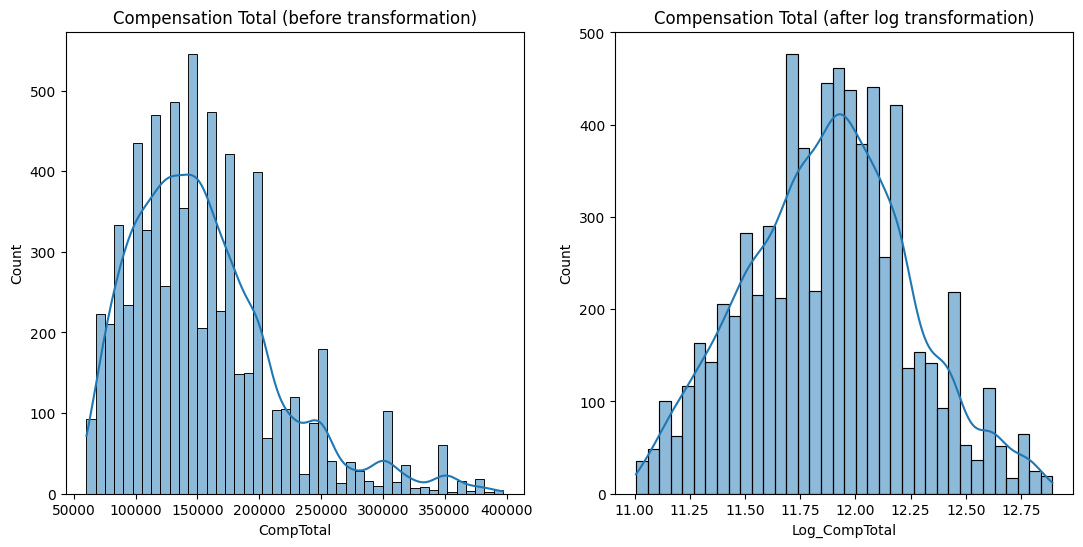

In [34]:
df['Log_CompTotal'] = np.log(df['CompTotal'])



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

sns.histplot(df['CompTotal'], kde=True, ax=ax[0])
sns.histplot(df['Log_CompTotal'], kde=True, ax=ax[1])

ax[0].set_title("Compensation Total (before transformation)")
ax[1].set_title("Compensation Total (after log transformation)")

print(f"Mean: {round(df['CompTotal'].mean(),2)}")
print(f"Median: {round(df['CompTotal'].median(),2)}")

plt.show()



### Age
Examine the demographic distribution of the survey participants.

- ~70% of Developers have between 25 and 44 years old

Skewness: 0.91
Kurtosis: 0.57


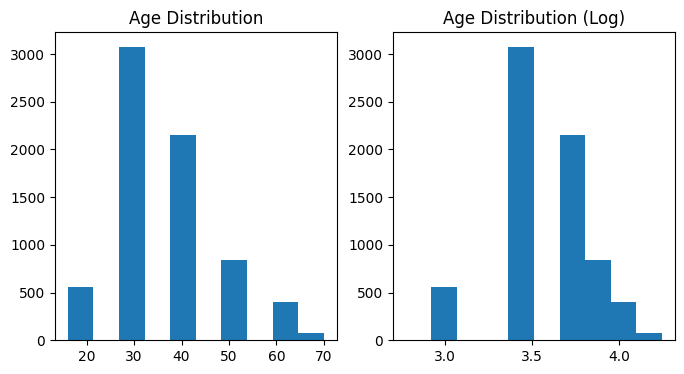

In [35]:
#Note that we changed the this is the Midpoint bewteen the Age ranges in the Orignal Data Set
df['Log_MidPointAge'] = np.log(df['MidPointAge'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].hist(df['MidPointAge'])
ax[0].set_title('Age Distribution')

ax[1].set_title('Age Distribution (Log)')
ax[1].hist(df['Log_MidPointAge'])

print(f"Skewness: {round(df['MidPointAge'].skew(),2)}")
print(f"Kurtosis: {round(df['MidPointAge'].kurt(),2)}")

plt.show()

### Experience

Evaluate the professional maturity in terms of coding and work experience represented in the dataset.

 - Most of the Software Developers in the survey have less than 25 years of experience. (should I apply Log)
 - The Data for all three metrics is Right-Skewed with a small amount of Software Developers having more than 25 years of work experience 

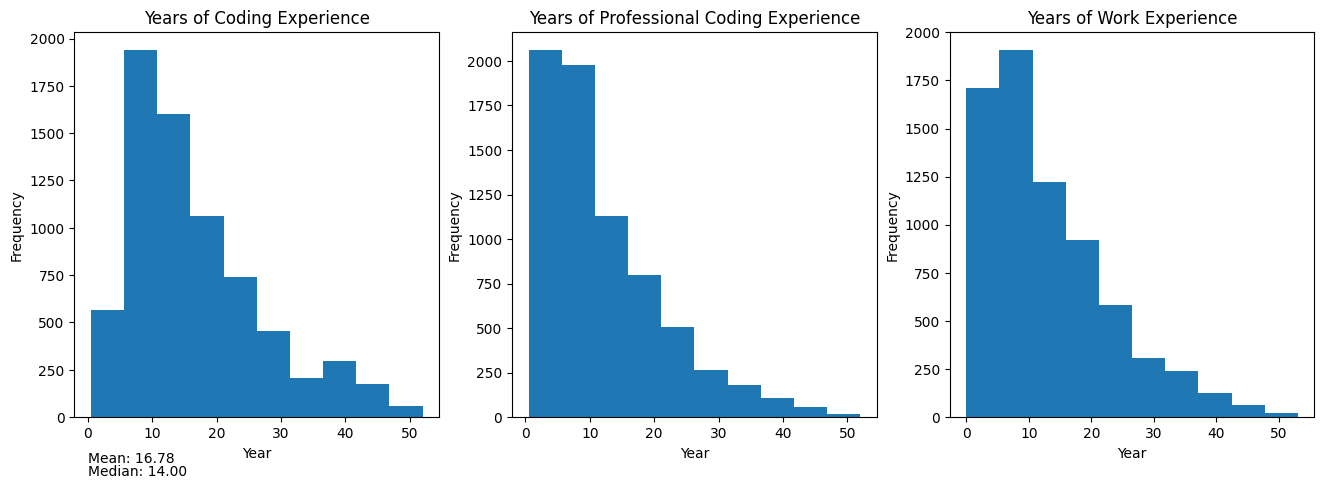

In [36]:
# Clip values less than 0.01 to be 0.01
df['YearsWorkExp'] = np.clip(df['YearsWorkExp'], 0.01, None)
df['Log_YearsCodeExp'] = np.log(df['YearsCodeExp'])
df['Log_YearsCodeProExp'] = np.log(df['YearsCodeProExp'])
df['Log_YearsWorkExp'] = np.log(df['YearsWorkExp'])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

# Histogram for YearsCodeExp with mean and median
mean_val = df['YearsCodeExp'].mean()
median_val = df['YearsCodeExp'].median()
ax[0].hist(df['YearsCodeExp'])
ax[0].set_title('Years of Coding Experience')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Frequency')
ax[0].text(0, -220,'Mean: {:.2f}'.format(mean_val), ha='left', va='center')
ax[0].text(0, -290, 'Median: {:.2f}'.format(median_val), ha='left', va='center')


ax[1].hist(df['YearsCodeProExp'])
ax[1].set_title('Years of Professional Coding Experience')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Frequency')


ax[2].hist(df['YearsWorkExp'])
ax[2].set_title('Years of Work Experience')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Frequency')

plt.show()

In [37]:
# median_val = df['YearsCodeExp'].median()
# ax = sns.hist(df['YearsCodeExp'])
# plt.title('Years of Coding Experience', fontsize=14)
# plt.show()

### Developer Type
 - ~50% of Developers are Full-Stack Developers and 20% Back-End
 - Most software developers work Remote

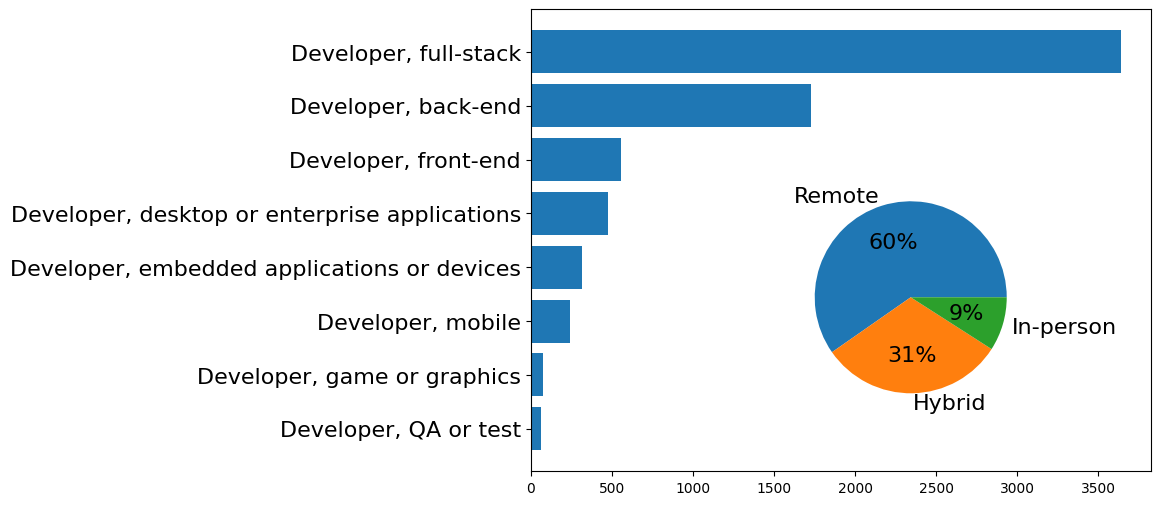

In [38]:
#Note that we changed the mid
worksetting = df['WorkSetting'].value_counts().sort_values(ascending=False)
jobs = df['JobRole'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(jobs.index, jobs.values)

# Increase the size of the y-tick labels
ax.tick_params(axis='y', labelsize=16)  # You can replace 'large' with a specific numeric value, like 12, 14, etc.

# Create an inset axis inside the main ax
axins = fig.add_axes([0.45, 0.20, 0.3, 0.4]) # Specify the position and size of the inset: [left, bottom, width, height]
axins.pie(worksetting.values, labels=worksetting.index, autopct='%1.0f%%', textprops={'fontsize': 16})

plt.show()

### Organization Type (Industry & Size)
 - The Software Developer Workforce is well spread out accross different Organization Sizes
 - Most Software Developers(63%)  Work for companies in the IS and IT services industry  
 
---

Since 40% of the Industry Data is Missing I will perform the following:
 1. Data Inputation using Most Common Class:  Fill the NaNs with the most common class (mode). In this case, it's "Information Services, IT, Software Development, or other Technology." 
 2. Indicator for Missingness: Create a new binary column that indicates whether the original data in 'Industry' was missing. This can capture any systematic patterns of missingness.

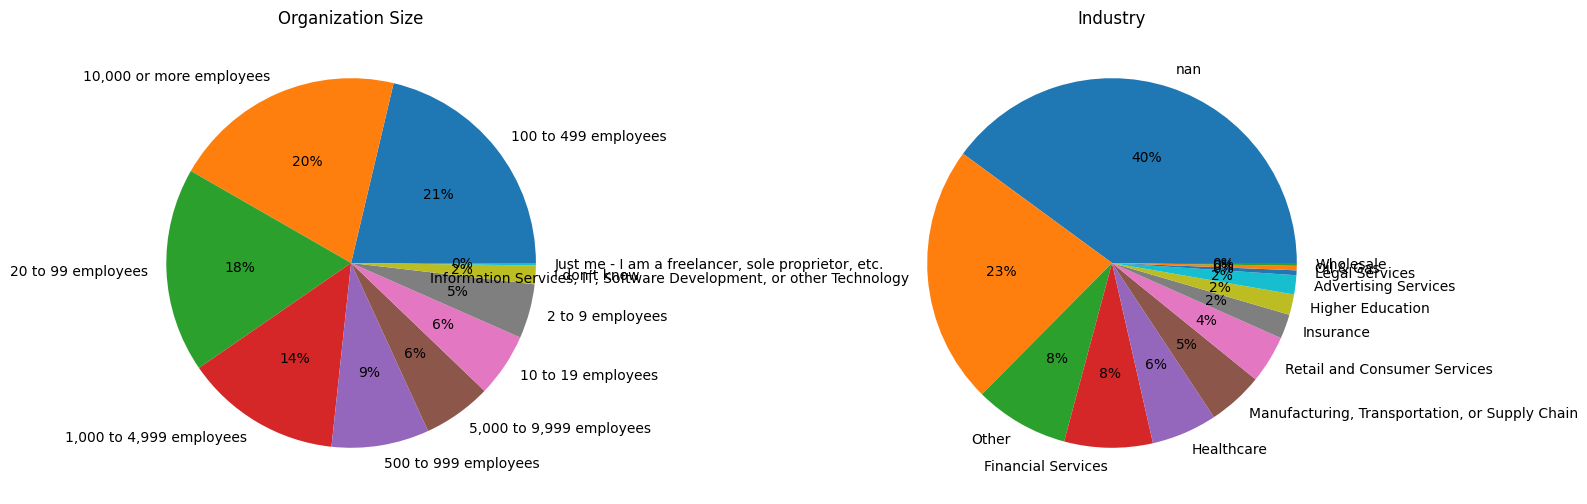

In [39]:
orgsize = df['OrgSize'].value_counts().sort_values(ascending=False)
industry = df['Industry'].value_counts(dropna=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].pie(orgsize.values, labels=orgsize.index, autopct='%1.0f%%')
ax[0].set_title("Organization Size")

ax[1].pie(industry, labels=industry.index, autopct='%1.0f%%')
ax[1].set_title("Industry")

plt.show()

In [40]:
df['Industry'].value_counts(dropna=False)

NaN                                                                    2836
Information Services, IT, Software Development, or other Technology    1608
Other                                                                   587
Financial Services                                                      549
Healthcare                                                              408
Manufacturing, Transportation, or Supply Chain                          345
Retail and Consumer Services                                            297
Insurance                                                               152
Higher Education                                                        127
Advertising Services                                                    119
Legal Services                                                           30
Oil & Gas                                                                28
Wholesale                                                                17
Name: Indust

In [41]:
df['Industry_is_missing'] = df['Industry'].isna().astype(int)
df['Industry'].fillna(df['Industry'].mode()[0], inplace=True)
# df = df[df['OrgSize'] != 'Just me - I am a freelancer, sole proprietor, etc.']

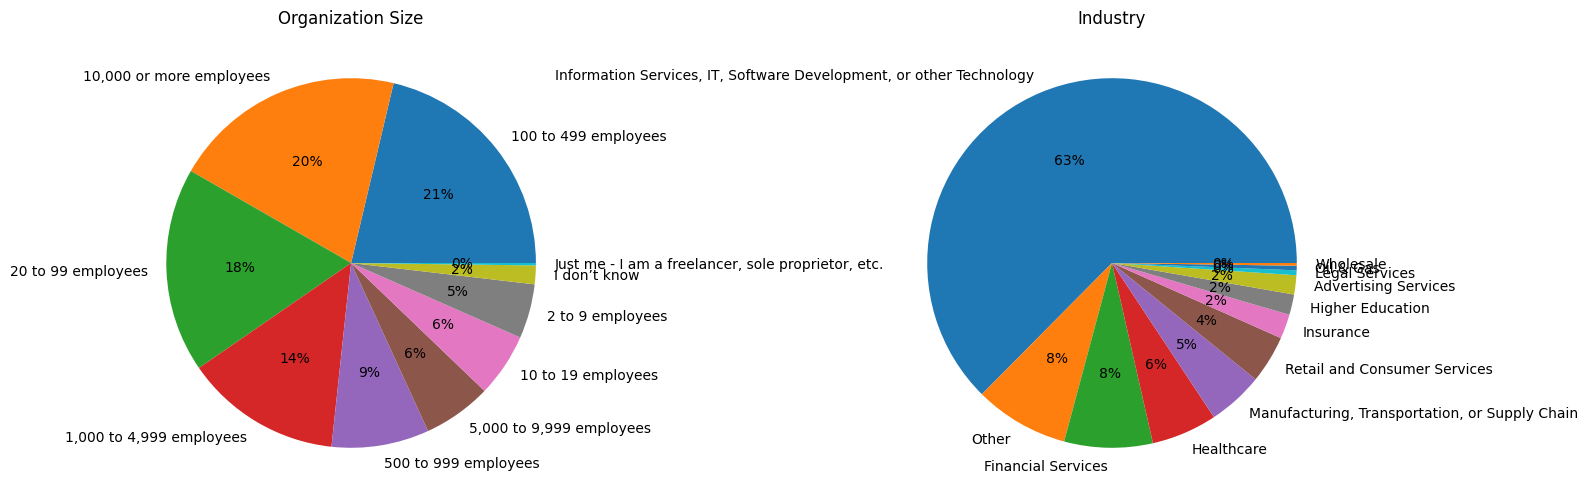

In [42]:
orgsize = df['OrgSize'].value_counts().sort_values(ascending=False)
industry = df['Industry'].value_counts(dropna=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].pie(orgsize.values, labels=orgsize.index, autopct='%1.0f%%')
ax[0].set_title("Organization Size")

ax[1].pie(industry, labels=industry.index, autopct='%1.0f%%')
ax[1].set_title("Industry")

plt.show()

In [43]:
df["OrgSize"].value_counts(dropna=False).sort_values(ascending=False)

100 to 499 employees                                  1513
10,000 or more employees                              1449
20 to 99 employees                                    1272
1,000 to 4,999 employees                               972
500 to 999 employees                                   606
5,000 to 9,999 employees                               426
10 to 19 employees                                     395
2 to 9 employees                                       338
I don’t know                                           116
Just me - I am a freelancer, sole proprietor, etc.      15
NaN                                                      1
Name: OrgSize, dtype: int64

In [44]:
OrgSizeMidpoints = {
    'NaN': None,
    'I don’t know': None,
    'Just me - I am a freelancer, sole proprietor, etc.': 1,
    '2 to 9 employees': 6,
    "10 to 19 employees": 15,
    "20 to 99 employees": 60,
    "100 to 499 employees": 300,
    "500 to 999 employees": 750,
    "1,000 to 4,999 employees": 3000,
    "5,000 to 9,999 employees": 7500,
    "10,000 or more employees": 10000,
}

df['MidPointOrgSize'] = df['OrgSize'].map(OrgSizeMidpoints)

In [45]:
df['MidPointOrgSize'].fillna(10_000, inplace=True)

In [46]:
df['MidPointOrgSize'].value_counts().sort_values(ascending=False)

10000.0    1566
300.0      1513
60.0       1272
3000.0      972
750.0       606
7500.0      426
15.0        395
6.0         338
1.0          15
Name: MidPointOrgSize, dtype: int64

### Education Level
Understand the educational backgrounds of the developers and how it varies within the dataset.

 - Most Software Developers (65%) have at a bachelors degree.
 - Almost all (92%) of software developes have some sort of secondary education
---
**NOTE**
- 'Something else' is challenging to interpret because it groups together a potentially diverse range of educational experiences. Since the number is small (>20) I will exclude it
- I will also drop for 'Primary/elementary' school due to a small number of 'respondants'

In [47]:
education = df['EdLevel'].value_counts(dropna=False)
education

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          4641
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       1122
Some college/university study without earning a degree                                 761
Associate degree (A.A., A.S., etc.)                                                    315
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     121
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         115
Something else                                                                          17
Primary/elementary school                                                               11
Name: EdLevel, dtype: int64

In [48]:
#Exclude 'Something Else' 'Primary/elementary school' 
df = df.loc[df['EdLevel'] != 'Something else']
df = df.loc[df['EdLevel'] != 'Primary/elementary school']
# df['EdLevel'] = df['EdLevel'].replace('Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 'Secondary School')
df.shape

(7075, 28)

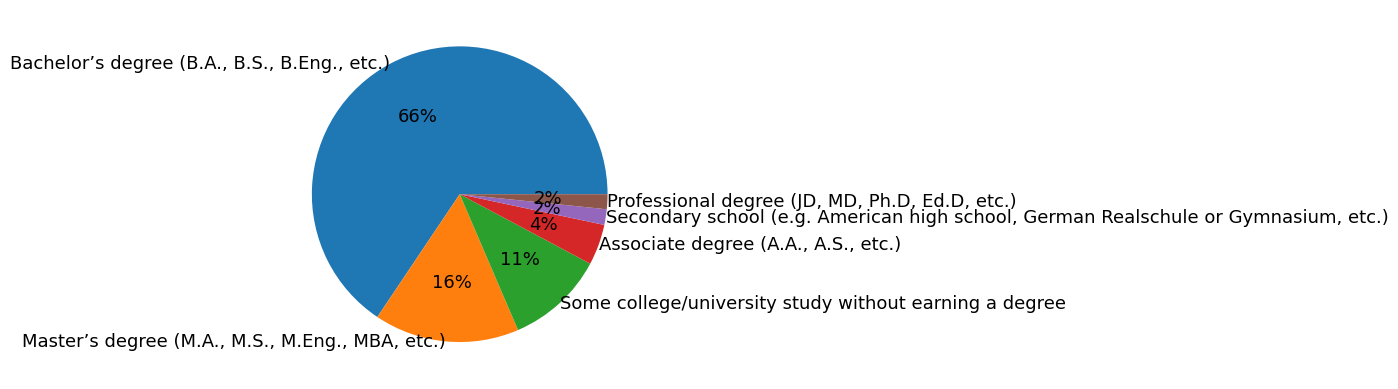

In [49]:
education = df['EdLevel'].value_counts(dropna=False)
plt.pie(education.values, labels=education.index, autopct='%1.0f%%', textprops={'fontsize': 13}, labeldistance=1)

plt.show()

In [50]:
# Define a mapping from education level to integers
ed_level_mapping = {
    # 'Primary/elementary school': 1, #Excluded from dataset
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 1,
    'Some college/university study without earning a degree': 2,
    'Associate degree (A.A., A.S., etc.)': 3,
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 4,
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 5,
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 6,
    #'Something else': 0.5 #Excluded from dataset
}

# Apply the mapping to the 'EdLevel' column
df['EdLevel_Encoded'] = df['EdLevel'].map(ed_level_mapping)

## Bivariative Analysis
- It involves the analysis of two variables, for the purpose of determining the empirical relationship between them.

### Numerical Variables

Checking the relationship for the numerical variables first

In [51]:
# Placing Target Variable (Compensation Total) last in the dataframe
if 'CompTotal' in df.columns and 'Log_CompTotal' in df.columns:
    cols = [col for col in df.columns if col not in ['CompTotal', 'Log_CompTotal']]
    cols += ['CompTotal', 'Log_CompTotal']
    df = df[cols]

In [52]:
df_numerical = df.select_dtypes(exclude=['object'])
df_numerical.columns

Index(['YearsCodeExp', 'YearsCodeProExp', 'YearsWorkExp', 'MidPointAge',
       'MeanYearsCodeExp', 'Log_MidPointAge', 'Log_YearsCodeExp',
       'Log_YearsCodeProExp', 'Log_YearsWorkExp', 'Industry_is_missing',
       'MidPointOrgSize', 'EdLevel_Encoded', 'CompTotal', 'Log_CompTotal'],
      dtype='object')

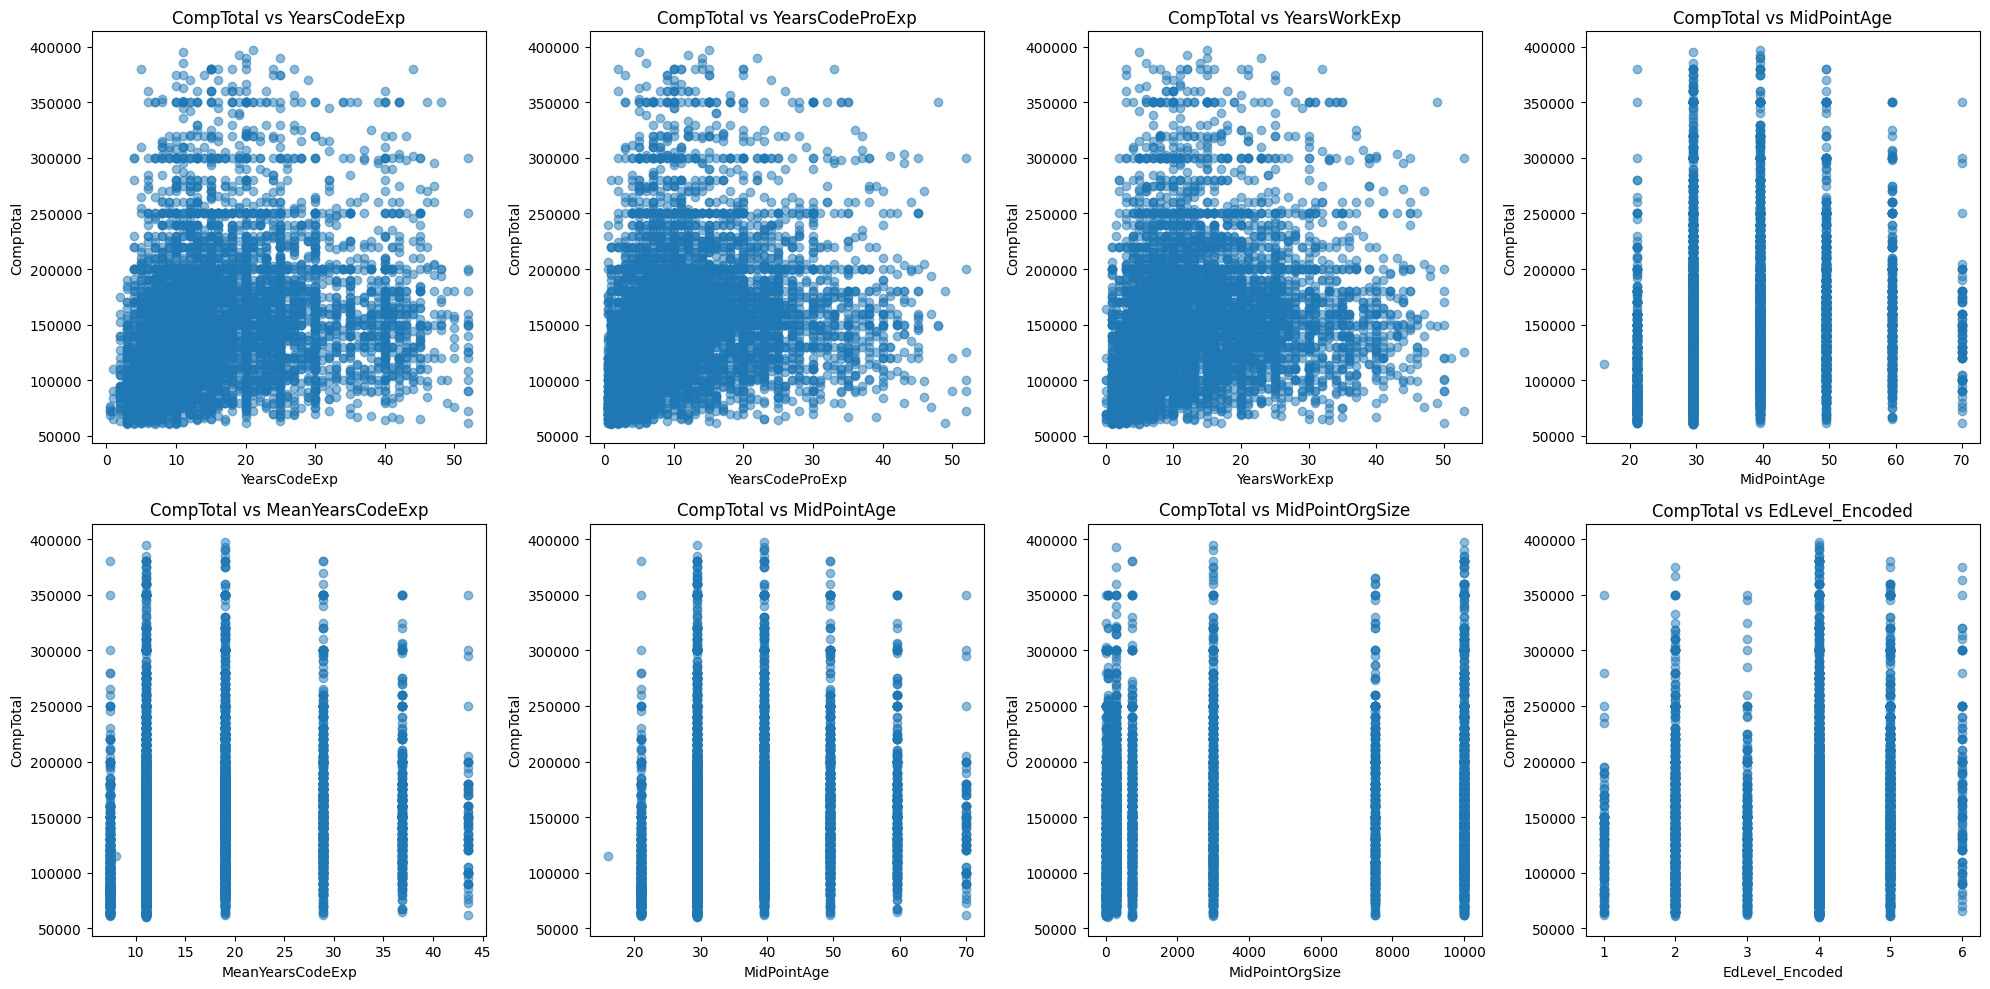

In [53]:
# List of columns to plot against 'Log_CompTotal'
columns = ['YearsCodeExp', 'YearsCodeProExp', 'YearsWorkExp', 'MidPointAge',
           'MeanYearsCodeExp', 'MidPointAge','MidPointOrgSize', 'EdLevel_Encoded']

# Number of rows and columns for subplot grid
n_rows = len(columns) // 4 + int(len(columns) % 4 > 0)
n_cols = 4

# Create a figure and a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Flatten the array of axes for easy iteration
axs = axs.ravel()

for i, col in enumerate(columns):
    axs[i].scatter(df[col], df['CompTotal'], alpha=0.5)
    axs[i].set_title(f'CompTotal vs {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('CompTotal')

# Hide any unused subplots
for i in range(len(columns), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

 - Compensation seems to show some linear relationship with experience-related features (YearsCodeExp, YearsCodeProExp, YearsWorkExp).

## Outliers (df1)

#### Work Experience
    1. Remove Workers who have more than 30 years of Professional Coding Experience and make less than 125,000
    
    2. Remove Workers who have more than 35 years of Coding Experience and make less than 125,000
    
    3. Remove Workers who have more than 40 years of Coding Experience and make less than 125,000
    
    4. Remove Workers who have less than 2 years of Professional Coding Experience and make more than 200,000
    
    5. Remove Workers who have less than 3 years of Coding Experience and make more than 200,000
    
    6. Remove Workers who have less than 4 years of Work Experience and make more than 250,000

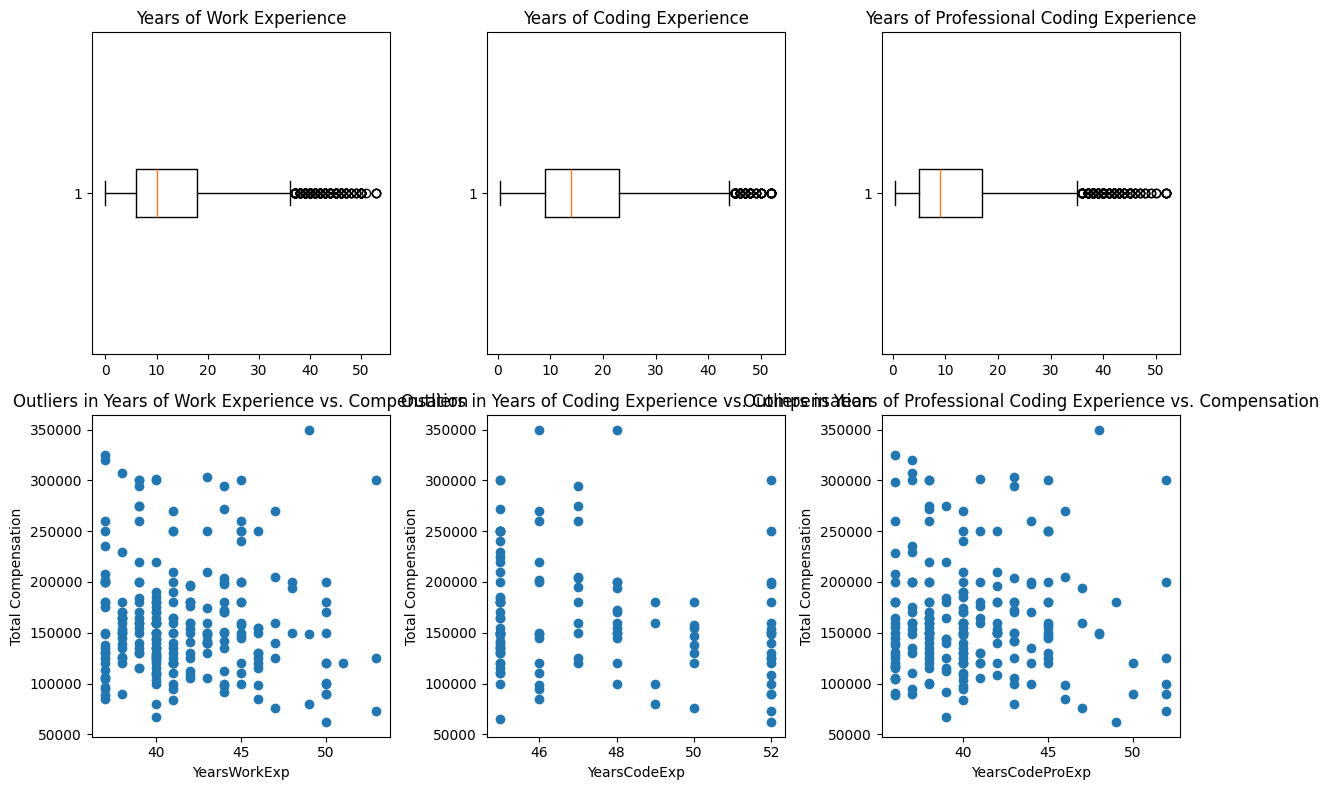

In [54]:
# Function to calculate bounds for outliers based on IQR
def calculate_bounds(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Set up the matplotlib figure and axes
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

# Titles for the plots
titles = ['Years of Work Experience', 'Years of Coding Experience', 'Years of Professional Coding Experience']

# Columns to plot
columns_to_plot = ['YearsWorkExp', 'YearsCodeExp', 'YearsCodeProExp']

# Loop through the columns and create the plots
for i, column in enumerate(columns_to_plot):
    # Calculate the bounds for outliers
    lower_bound, upper_bound = calculate_bounds(df[column])
    
    # Identify outliers
    outliers = df[(df[column] > upper_bound) | (df[column] < lower_bound)]
    
    # Boxplot for the experience columns
    ax[0][i].boxplot(df[column].dropna(), vert=False)  # Drop NA values for plotting
    ax[0][i].set_title(titles[i])
    
    # Scatter plot for outliers vs. Total Compensation
    ax[1][i].scatter(outliers[column], outliers['CompTotal'])
    ax[1][i].set_xlabel(column)
    ax[1][i].set_ylabel('Total Compensation')
    ax[1][i].set_title(f'Outliers in {titles[i]} vs. Compensation')

# Adjust layout for better fit and display the plot
plt.tight_layout()
plt.show()

In [55]:
df.shape

(7075, 29)

In [56]:
df1 = df[~((df['YearsCodeProExp'] >= 40) & (df['CompTotal'] < 125000))] #Remove Workers who have more than 40 years of Professional Coding Experience and make less than 125,000
df1 = df1[~((df1['YearsCodeExp'] >= 45) & (df1['CompTotal'] < 125000))] #Remove Workers who have more than 45 years of Coding Experience and make less than 125,000
df1 = df1[~((df1['YearsWorkExp'] >= 50) & (df1['CompTotal'] < 125000))] #Remove Workers who have more than 50 years of Coding Experience and make less than 125,000
df1.shape

(7035, 29)

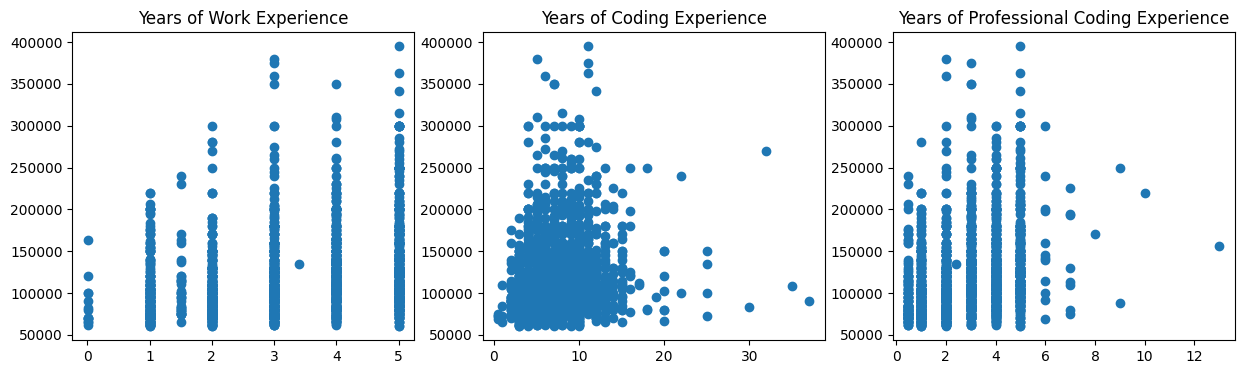

In [57]:
#Investigating Respondants with few years of experience
data1 = df1.loc[df1['YearsWorkExp'] < 6]
data2 = df1.loc[df1['YearsCodeExp'] < 8]
data3 = df1.loc[df1['YearsCodeProExp'] < 4]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

ax[0].scatter(data1['YearsWorkExp'], data1['CompTotal'])
ax[0].set_title('Years of Work Experience')

ax[1].scatter(data1['YearsCodeExp'], data1['CompTotal'])
ax[1].set_title('Years of Coding Experience')

ax[2].scatter(data1['YearsCodeProExp'], data1['CompTotal'])
ax[2].set_title('Years of Professional Coding Experience')

plt.show()

In [58]:
#Dropping respondants that make large salaries with only a few years of experience since they are not repesentative
df1 = df1[~((df1['YearsCodeProExp'] < 3) & (df1['CompTotal'] > 200_000))]
df1 = df1[~((df1['YearsCodeExp'] < 4) & (df1['CompTotal'] > 200_000))]
df1 = df1[~((df1['YearsWorkExp'] < 5) & (df1['CompTotal'] > 250_000))]
df1.shape

(7002, 29)

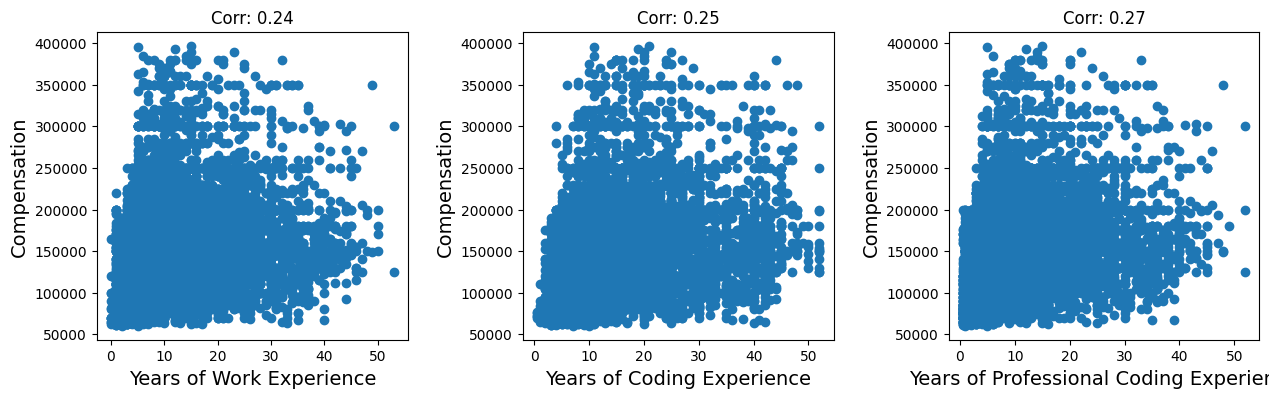

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
plt.subplots_adjust(wspace=0.37) 

axs = axs.ravel()

ax[0].scatter(df1['YearsWorkExp'], df1['CompTotal'])
# ax[0].set_title('Years of Work Experience vs Compensation', fontsize=12)
ax[0].set_xlabel('Years of Work Experience', fontsize=14)
ax[0].set_ylabel('Compensation', fontsize=14)
corr_1, _ = pearsonr(df1['YearsWorkExp'], df1['CompTotal'])
ax[0].title.set_text(f'Corr: {corr_1:.2f}')

ax[1].scatter(df1['YearsCodeExp'], df1['CompTotal'])
# ax[1].set_title('Years of Coding Experience vs Compensation', fontsize=12)
ax[1].set_xlabel('Years of Coding Experience', fontsize=14)
ax[1].set_ylabel('Compensation', fontsize=14)
corr_2, _ = pearsonr(df1['YearsCodeExp'], df1['CompTotal'])
ax[1].title.set_text(f'Corr: {corr_2:.2f}')

ax[2].scatter(df1['YearsCodeProExp'], df1['CompTotal'])
# ax[2].set_title('Years of Professional Coding Experience vs Compensation', fontsize=12)
ax[2].set_xlabel('Years of Professional Coding Experience', fontsize=14)
ax[2].set_ylabel('Compensation', fontsize=14)
corr_2, _ = pearsonr(df1['YearsCodeProExp'], df1['CompTotal'])
ax[2].title.set_text(f'Corr: {corr_2:.2f}')

plt.show()

#### Job Role

- Analyzing the 3 most common Job Roles among software developers

**Outliers**

1. Remove Full-Stack Dev w/ more than 50 Yrs of Professional Coding Experience that make less than 200,000
2. Remove Front-End Dev w/ more than 35 Yrs of Professional Coding Experience and make less than 200,000


In [60]:
df1['JobRole'].value_counts()

Developer, full-stack                            3589
Developer, back-end                              1707
Developer, front-end                              553
Developer, desktop or enterprise applications     461
Developer, embedded applications or devices       315
Developer, mobile                                 236
Developer, game or graphics                        77
Developer, QA or test                              64
Name: JobRole, dtype: int64

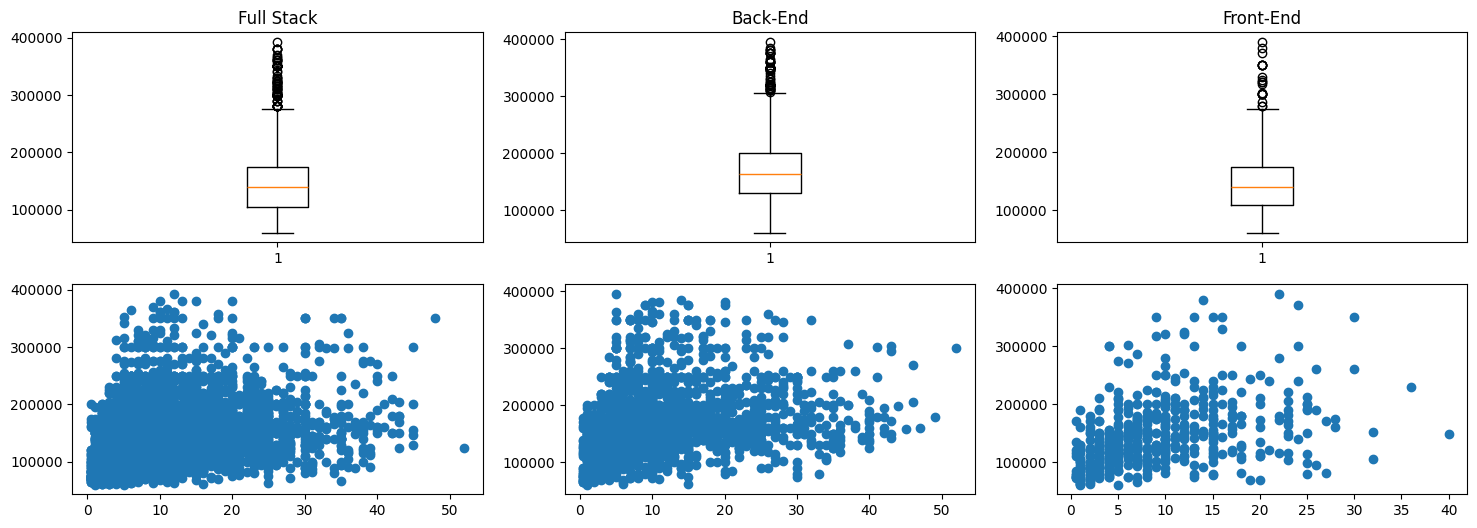

In [61]:
df_fs = df1.loc[df1['JobRole'] == 'Developer, full-stack']
df_be = df1.loc[df1['JobRole'] == 'Developer, back-end']
df_fe = df1.loc[df1['JobRole'] == 'Developer, front-end']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,6))

ax[0][0].boxplot(df_fs['CompTotal'])
ax[0][0].set_title('Full Stack')
ax[1][0].scatter(df_fs['YearsCodeProExp'],df_fs['CompTotal'])

ax[0][1].boxplot(df_be['CompTotal'])
ax[0][1].set_title('Back-End')
ax[1][1].scatter(df_be['YearsCodeProExp'],df_be['CompTotal'])

ax[0][2].boxplot(df_fe['CompTotal'])
ax[0][2].set_title('Front-End')
ax[1][2].scatter(df_fe['YearsCodeProExp'],df_fe['CompTotal'])

plt.show()

In [62]:
# Remove Full-Stack Dev w/ more than 50 Yrs of Professional Coding Experience that make less than 200,000
df1 = df1[~((df1['JobRole'] == 'Developer, full-stack') & (df1['YearsCodeProExp'] > 50) & (df1['CompTotal'] < 200_000))] 

# Remove Front-End Dev w/ more than 35 Yrs of Professional Coding Experience and make less than 200,000
df1 = df1[~((df1['JobRole'] == 'Developer, front-end') & (df1['YearsCodeProExp'] > 35) & (df1['CompTotal'] < 200_000))]
df1.shape

(7000, 29)

## Addressing Remaning Nulls
 - Removing Nulls for `LanguagesHaveWorkedWitk` and `DatabasesHaveWorkedWith` return lower Accuracy score so Im keeping the Nulls for these 2 columns

In [63]:
# Calculate and display the total and percentage of null values per column
nulls_tab = pd.concat([
    df1.isnull().sum().rename('Total'), 
    df1.isnull().mean().rename('Percent').mul(100)
], axis=1).sort_values(by='Total', ascending=False).head(5)

nulls_tab

,Total,Percent
ProfessionalTech,2095,29.928571
PlatformHaveWorkedWith,1371,19.585714
DatabaseHaveWorkedWith,948,13.542857
LanguageHaveWorkedWith,14,0.200000
OrgSize,1,0.014286


In [64]:
# df1 = df1.dropna(subset=['LanguageHaveWorkedWith'])
df1.shape

(7000, 29)

## Feature Engineering

### Experience Squared

Each year that you gain experience, the experience becomes more valuable so its exponential. 

In [65]:
df1['YearsCodeExp_2'] = df1['YearsCodeExp'] ** 2
df1['YearsCodeProExp_2'] = df1['YearsCodeProExp'] ** 2
df1['YearsWorkExp_2'] = df1['YearsWorkExp'] ** 2

df1['Log_YearsCodeExp_2'] = np.log(df1['YearsCodeExp_2'])
df1['Log_YearsCodeProExp_2'] = np.log(df1['YearsCodeProExp_2'])
df1['Log_YearsWorkExp_2'] = np.log(df1['YearsWorkExp_2'])

### Rating

- New Variable that combines Education Level and Years of Professional Coding Experience (Experience type with greater correlation with Total Compensation
---
**WARNING**: I need to make this variable more unique in order to avoid multicolinearity

In [66]:
# Define weights
experience_weight = 0.80
education_weight = 0.20

# Calculate the ratings with Experience
df1['Rating1'] = (df1['Log_YearsCodeProExp'] * experience_weight) + (df1['EdLevel_Encoded'] * education_weight)
df1['Rating2'] = (df1['Log_YearsCodeExp'] * experience_weight) + (df1['EdLevel_Encoded'] * education_weight)
df1['Rating3'] = (df1['Log_YearsWorkExp'] * experience_weight) + (df1['EdLevel_Encoded'] * education_weight)

# Calculate the ratings with Experience Squared
df1['Rating1.1'] = (df1['Log_YearsCodeProExp_2'] * experience_weight) + (df1['EdLevel_Encoded'] * education_weight)
df1['Rating2.1'] = (df1['Log_YearsCodeExp_2'] * experience_weight) + (df1['EdLevel_Encoded'] * education_weight)
df1['Rating3.1'] = (df1['Log_YearsWorkExp_2'] * experience_weight) + (df1['EdLevel_Encoded'] * education_weight)


print(f"Correlation Rating 1: {round(df1['Rating1'].corr(df1['Log_CompTotal']),3)} | Correlation Rating 1.1: {round(df1['Rating1.1'].corr(df1['Log_CompTotal']),3)}")
print(f"Correlation Rating 2: {round(df1['Rating2'].corr(df1['Log_CompTotal']),3)} | Correlation Rating 2.1: {round(df1['Rating2.1'].corr(df1['Log_CompTotal']),3)}")
print(f"Correlation Rating 3: {round(df1['Rating3'].corr(df1['Log_CompTotal']),3)} | Correlation Rating 3.1: {round(df1['Rating3.1'].corr(df1['Log_CompTotal']),3)}")

df1.drop(['Rating2', 'Rating3'], axis=1, inplace=True, errors='ignore')

Correlation Rating 1: 0.432 | Correlation Rating 1.1: 0.426
Correlation Rating 2: 0.368 | Correlation Rating 2.1: 0.364
Correlation Rating 3: 0.398 | Correlation Rating 3.1: 0.392


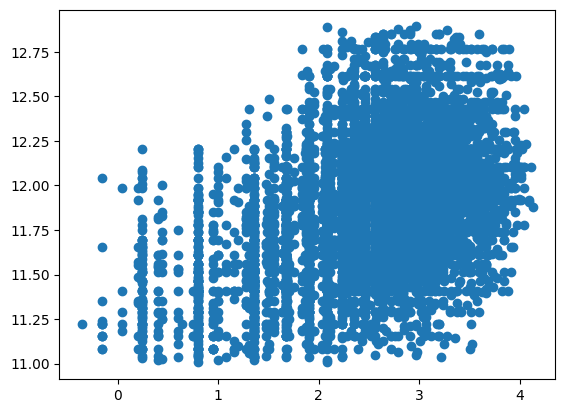

In [67]:
plt.scatter(df1['Rating1'], df1['Log_CompTotal'])

## Multivaritive Study

Understand how the independepent variables relate to the dependent variable.

In [68]:
types = df1.dtypes.reset_index()
types.columns = ['Column', 'DataType'] 
nulls = df1.isnull().sum().reset_index()
nulls.columns = ['Column', 'Nulls'] 
df_info = pd.merge(types, nulls, on='Column')
df_info.sort_values(by='Nulls', ascending=False)

,Column,DataType,Nulls
15,ProfessionalTech,object,2095
14,PlatformHaveWorkedWith,object,1371
13,DatabaseHaveWorkedWith,object,948
12,LanguageHaveWorkedWith,object,14
9,OrgSize,object,1
0,CodingRole,object,0
24,Industry_is_missing,int32,0
25,MidPointOrgSize,float64,0
26,EdLevel_Encoded,int64,0
27,CompTotal,float64,0


In [69]:
# Create a list of column names, with 'CompTotal' and 'Log_CompTotal' at the end
cols = [col for col in df1.columns if col not in ['CompTotal', 'Log_CompTotal']]
cols += ['CompTotal', 'Log_CompTotal']  # Add the desired columns to the end

# Reorder the DataFrame according to the new column order
df1 = df1[cols]

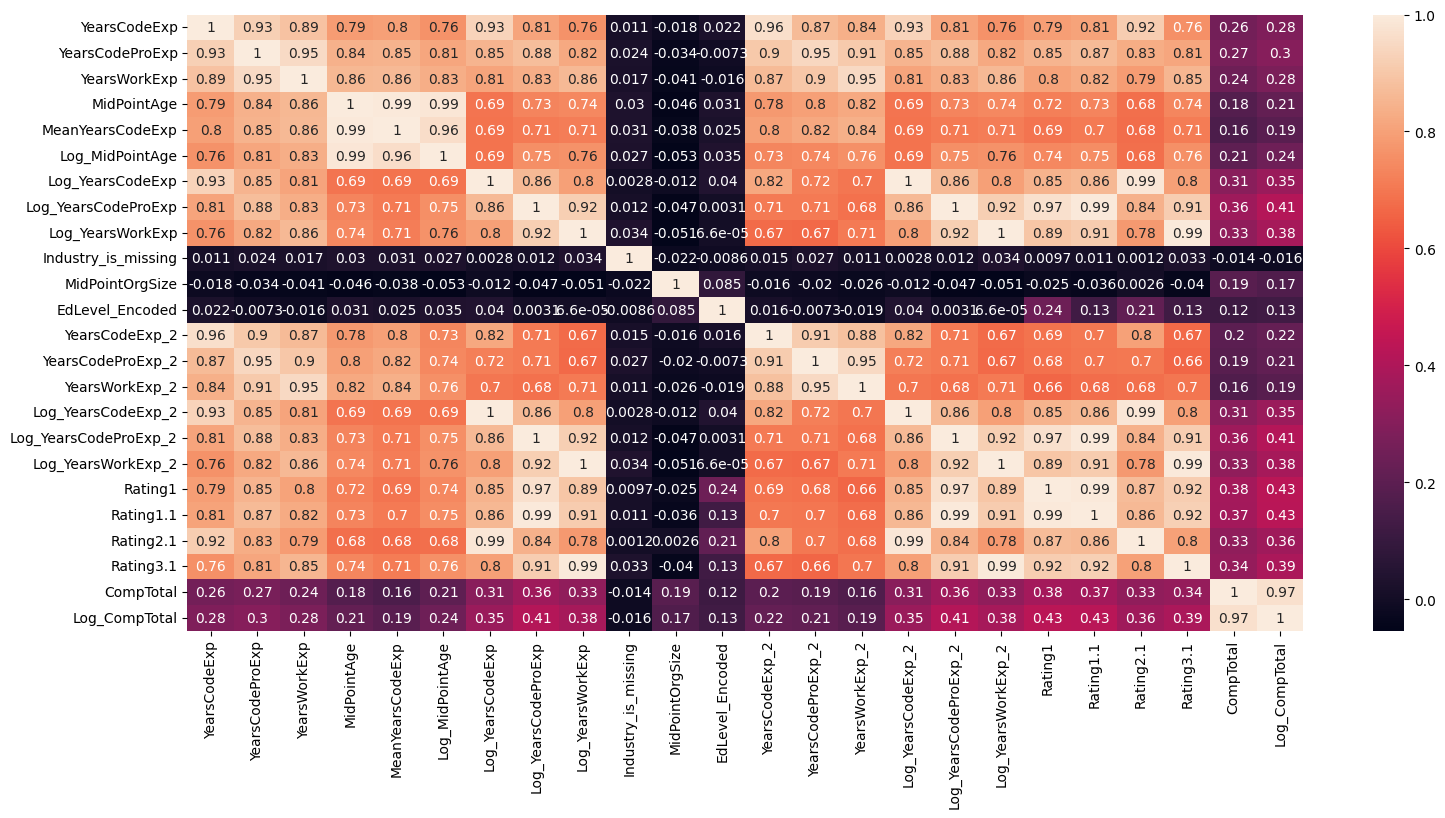

In [70]:
# Create an object with the Correlation between the Features
df1_numerical = df1.select_dtypes(exclude=['object'])
corr = df1_numerical.corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (18,8))
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

In [71]:
df1.columns

Index(['CodingRole', 'Age', 'EmploymentStatus', 'WorkSetting', 'EdLevel',
       'YearsCodeExp', 'YearsCodeProExp', 'YearsWorkExp', 'JobRole', 'OrgSize',
       'Country', 'Currency', 'LanguageHaveWorkedWith',
       'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'ProfessionalTech',
       'Industry', 'MidPointAge', 'MeanYearsCodeExp', 'GroupedJobRole',
       'Log_MidPointAge', 'Log_YearsCodeExp', 'Log_YearsCodeProExp',
       'Log_YearsWorkExp', 'Industry_is_missing', 'MidPointOrgSize',
       'EdLevel_Encoded', 'YearsCodeExp_2', 'YearsCodeProExp_2',
       'YearsWorkExp_2', 'Log_YearsCodeExp_2', 'Log_YearsCodeProExp_2',
       'Log_YearsWorkExp_2', 'Rating1', 'Rating1.1', 'Rating2.1', 'Rating3.1',
       'CompTotal', 'Log_CompTotal'],
      dtype='object')

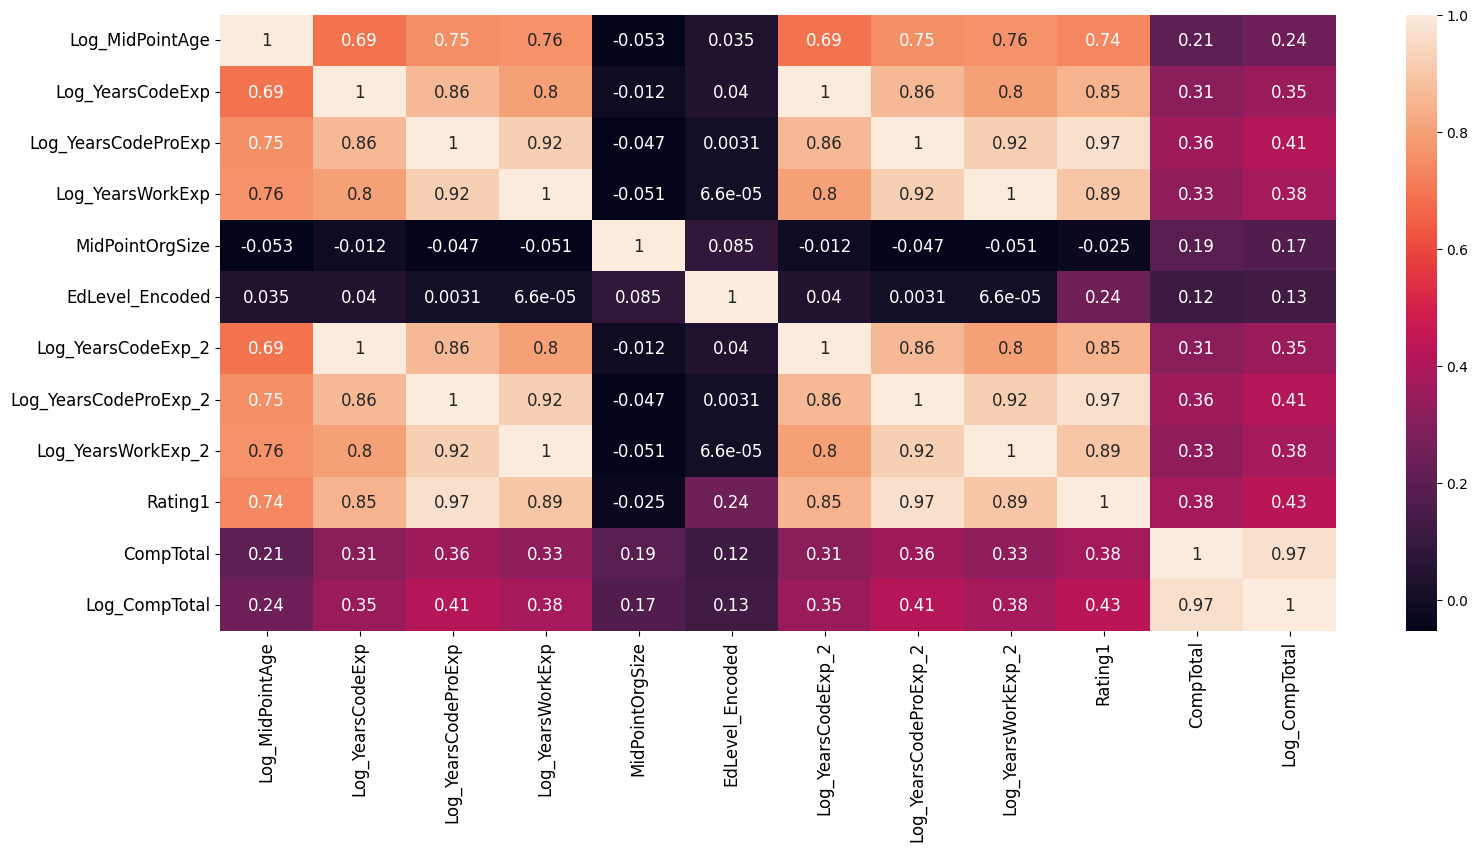

In [72]:
# Create an object with the Correlation between the Features
df1_selected = df1[['Log_MidPointAge', 'Log_YearsCodeExp', 'Log_YearsCodeProExp',
       'Log_YearsWorkExp', 'MidPointOrgSize','EdLevel_Encoded', 'Log_YearsCodeExp_2', 'Log_YearsCodeProExp_2',
       'Log_YearsWorkExp_2', 'Rating1','CompTotal', 'Log_CompTotal']]
corr = df1_selected.corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (18,8))
sns.heatmap(corr, annot=True, ax=ax, annot_kws={"size": 12})

# Increase the size of the labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust x-axis labels size here
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust y-axis labels size here

plt.show()

## Significance Tests

### Ranking of Correlations
*Not including variables that correlated with each other*
1. Rating (WorkExp & Ed. Level)
2. Log_MidPointAge
3. Log_MidPointOrgSize
4. Log_EdLevel

## Data Pre-Processing
 - In this step I will do my final cleaning and Transformation to make sure the data is suitable for a Machine Learning model

In [73]:
df1.columns

Index(['CodingRole', 'Age', 'EmploymentStatus', 'WorkSetting', 'EdLevel',
       'YearsCodeExp', 'YearsCodeProExp', 'YearsWorkExp', 'JobRole', 'OrgSize',
       'Country', 'Currency', 'LanguageHaveWorkedWith',
       'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'ProfessionalTech',
       'Industry', 'MidPointAge', 'MeanYearsCodeExp', 'GroupedJobRole',
       'Log_MidPointAge', 'Log_YearsCodeExp', 'Log_YearsCodeProExp',
       'Log_YearsWorkExp', 'Industry_is_missing', 'MidPointOrgSize',
       'EdLevel_Encoded', 'YearsCodeExp_2', 'YearsCodeProExp_2',
       'YearsWorkExp_2', 'Log_YearsCodeExp_2', 'Log_YearsCodeProExp_2',
       'Log_YearsWorkExp_2', 'Rating1', 'Rating1.1', 'Rating2.1', 'Rating3.1',
       'CompTotal', 'Log_CompTotal'],
      dtype='object')

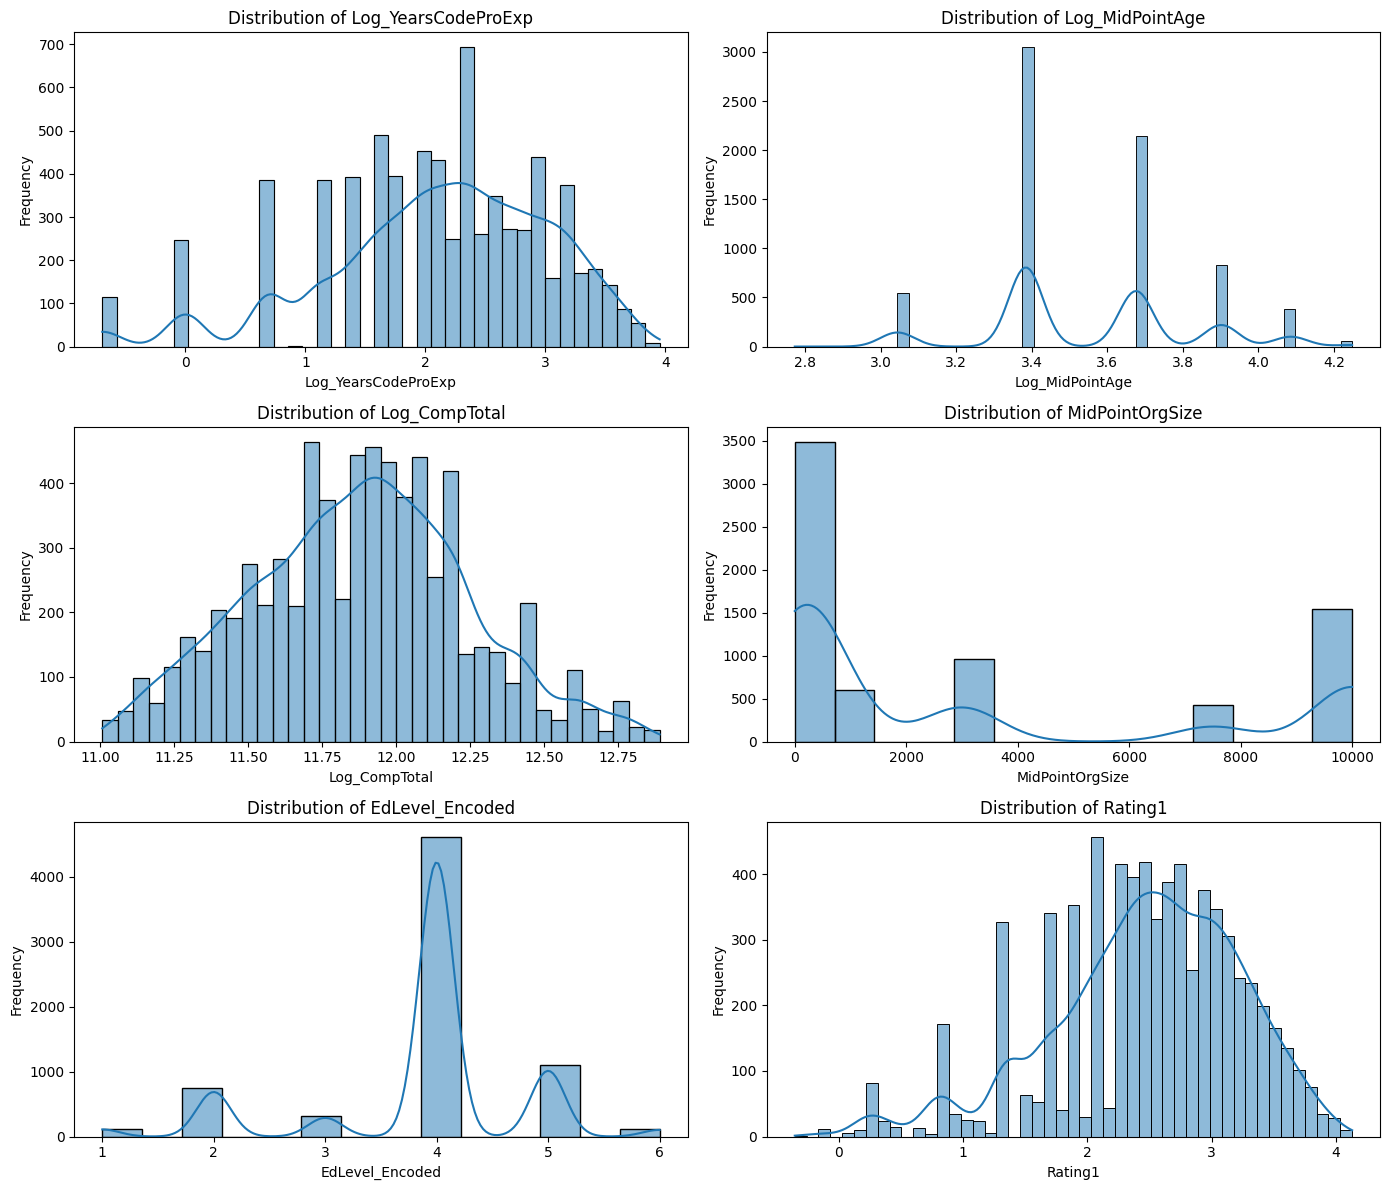

In [74]:
selected_features = ['Log_YearsCodeProExp', 'Log_MidPointAge', 'Log_CompTotal', 'MidPointOrgSize', 'EdLevel_Encoded', 'Rating1']
# Number of rows/columns for the subplot grid
num_rows = len(selected_features) // 2
num_cols = 2

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 4 * num_rows))

# Flatten the axes array for easy iterating
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    # Plot the distribution of the feature on the respective subplot
    sns.histplot(df1[feature], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()

### Feature Selection
 - Selecting the features that contribute the most to our Total Compensation (target variable).
     1. Log_YearsCodeProExp
     2. Log_MidPointAge
     3. Log_CompTotal
     4. MidPointOrgSize
     5. EdLevel_Encoded
     6. Rating1
     7. JobRole
     8. WorkSetting
     9. Industry
     10. Industry_is_missing
     

In [75]:
df_train1 = df1[['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'MidPointOrgSize', 'EdLevel_Encoded', 'Rating1',
             'JobRole','Industry','Industry_is_missing', 'Log_CompTotal']]


df_train1.shape

(7000, 9)

### Encoding Remaining Categorical Features

In [76]:
#Evaluate nulls again
total = df_train1.isnull().sum().sort_values(ascending=False)
percent = (df_train1.isnull().sum()/df_train1.isnull().count()).sort_values(ascending=False)
types = df_train1.dtypes
nulls_tab = pd.concat([types,total,percent], axis=1, keys=['Type', 'Total', 'Percent'])
nulls_tab.head(10)

,Type,Total,Percent
LanguageHaveWorkedWith,object,14,0.002000
DatabaseHaveWorkedWith,object,948,0.135429
MidPointOrgSize,float64,0,0.000000
EdLevel_Encoded,int64,0,0.000000
Rating1,float64,0,0.000000
JobRole,object,0,0.000000
Industry,object,0,0.000000
Industry_is_missing,int32,0,0.000000
Log_CompTotal,float64,0,0.000000


In [77]:
df_train1_encoded = pd.get_dummies(df_train1, columns=['JobRole', 'Industry'], dtype=int)

# Split the 'LanguageHaveWorkedWith' column and create dummy variables
language_dummies = df_train1['LanguageHaveWorkedWith'].str.get_dummies(sep=';')
database_dummies = df_train1['DatabaseHaveWorkedWith'].str.get_dummies(sep=';')

# Join the dummy variables with the original DataFrame
df_train1_encoded = df_train1_encoded.join(language_dummies)
df_train1_encoded = df_train1_encoded.join(database_dummies)

df_train1_encoded = df_train1_encoded.drop(columns=['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith'], axis=1)

df_train1_encoded.reset_index(drop=True, inplace=True) #Make sure we reset the index since we've deleted some rows before
df_train1_encoded.head()

,MidPointOrgSize,EdLevel_Encoded,Rating1,Industry_is_missing,Log_CompTotal,"JobRole_Developer, QA or test","JobRole_Developer, back-end","JobRole_Developer, desktop or enterprise applications","JobRole_Developer, embedded applications or devices","JobRole_Developer, front-end",...,Neo4J,Oracle,PostgreSQL,RavenDB,Redis,SQLite,Snowflake,Solr,Supabase,TiDB
0,7500.0,4,3.308395,0,12.429216,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,300.0,4,2.356728,1,11.957611,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,3000.0,2,1.278890,0,11.813030,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,15.0,4,1.678890,0,11.289782,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,6.0,4,2.557780,0,11.225243,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0


In [78]:
df_train1_encoded.isnull().sum()

MidPointOrgSize        0
EdLevel_Encoded        0
Rating1                0
Industry_is_missing    0
Log_CompTotal          0
                      ..
SQLite                 0
Snowflake              0
Solr                   0
Supabase               0
TiDB                   0
Length: 108, dtype: int64

## Modeling

### Split the Data
 1. Split the data into x, independent variables and y, dependent variables
 2. Split `x` and `y` into Training Set (80%) and Testing Set (20%)

In [79]:
x = df_train1_encoded.drop(columns='Log_CompTotal')
y = df_train1_encoded['Log_CompTotal']

We will split the data into Training Set and Testing Set

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Feature Standardization
- The primary reason for scaling features (independent variables) is to ensure that all of them contribute equally to the prediction and to help some algorithms
- Refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance).
- It's done by subtracting the mean value of the feature and then dividing by the standard deviation.
---
**NOTE:** We excluded this step since it was adding little value to our project and making the coefficients harder to interprete.

In [81]:
# # Scaling features
# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

### Train the model

 - **Ordinary Least Squares**
    - Seeks to minimize the sum of squared differences between observed and predicted values, providing an estimate of the relationship between variables.
    - Assumes linearity, no multicollinearity, and that errors are normally distributed and independent.
---
 - **Ridge Regression**
    - Useful when dealing with multicollinearity (independent variables are highly correlated).
    - It adds a regularization term (L2 penalty) to the OLS loss function to prevent overfitting.
---
 - **Lasso Regression**
    - Similar to Ridge, but uses L1 penalty which can lead to sparse models (some coefficients can become zero).
    - Good for feature selection.
---
 - **Elastic Net Regression**
    - Combines features of both Ridge and Lasso.
    - Has two parameters to control L1 and L2 regularization.
---
 - **Support Vector Regression (SVR)**
    - Uses Support Vector Machine (SVM) concept but for regression.
    - Good for small datasets and non-linear problems.
    - can be sensitive to the scale of the input data. (Make sure you scale the data properly before using this method)
---
 - **Decision Tree Regression**
    - Non-linear model, good for complex datasets.
    - Can capture complex relationships but may overfit.

In [82]:
# Initialize models with a range of hyperparameters
model_params = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters to tune
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {'alpha': [0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]}
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [3, 5, 7]}
    }
}

best_params = {}
for name, mp in model_params.items():
    grid_search = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)
    best_params[name] = grid_search.best_params_

# Print best parameters for each model
for model, params in best_params.items():
    print(f"Best parameters for {model}: {params}")

Best parameters for LinearRegression: {}
Best parameters for Ridge: {'alpha': 10.0}
Best parameters for Lasso: {'alpha': 0.1}
Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.2}
Best parameters for DecisionTreeRegressor: {'max_depth': 5}


In [83]:
all_results = []
n = x_test.shape[0]
p = x_test.shape[1]

for name, mp in model_params.items():
    start_time = time.time()  # Start timer
    model = mp['model'].set_params(**best_params[name])
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    end_time = time.time()  # End timer
    duration = end_time - start_time  # Calculate duration

    mse = round(mean_squared_error(y_test, y_hat), 2)
    r2 = round(r2_score(y_test, y_hat), 2)
    adjusted_r2 = round(1 - (1 - r2) * (n - 1) / (n - p - 1), 2)

    all_results.append({
        'Model': name,
        'Best Params': best_params[name],
        'MSE': mse,
        'R^2': r2,
        'Adjusted R^2': adjusted_r2,
        # 'Duration (seconds)': duration  # Add duration to results
    })

# Convert all_results to a DataFrame
df_results = pd.DataFrame(all_results)

styled_df = (
    df_results.style
    .highlight_max(subset=['R^2', 'Adjusted R^2'], color='lightgreen')
    .highlight_min(subset=['MSE'], color='lightgreen')
)

styled_df
df_results

,Model,Best Params,MSE,R^2,Adjusted R^2
0,LinearRegression,{},0.08,0.42,0.37
1,Ridge,{'alpha': 10.0},0.08,0.42,0.37
2,Lasso,{'alpha': 0.1},0.13,0.08,0.00
3,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.2}",0.11,0.24,0.18
4,DecisionTreeRegressor,{'max_depth': 5},0.10,0.32,0.26


### Evaluate & Interprete the Model
 - **Residual Sum of Squares (RSS)**: A measure of the model's prediction error.
 - **Variance (R-squared)**: It provides a measure of how well the model's predictions match the true values.
 - **Adjusted R-Square**
 - **Coefficients**: represents the expected change in the dependent variable for a one-unit change in the independent variable, holding all other independent variables constant. In other words, it tells you the strength and direction of the relationship between each independent variable and the dependent variable.
 - **Intercept**: The intercept is a constant that represents the expected mean value of the dependent variable when all independent variables are set to zero. It's the point where the best-fit regression line crosses the y-axis in a 2D plot (if you're plotting the relationship between the dependent variable and one independent variable).

In [84]:
# Initialize and fit the model with statsmodels for detailed statistics
# x_train_sm = sm.add_constant(x_train)  # Adding a constant for intercept
model = sm.OLS(y_train, x_train)
results = model.fit()

# Display the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_CompTotal   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     36.17
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        21:19:40   Log-Likelihood:                -830.74
No. Observations:                5600   AIC:                             1873.
Df Residuals:                    5494   BIC:                             2576.
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## Model Diagnostics

### QQ-Plot
- A QQ plot is a great way to determine whether residuals from regression analysis are normally distributed. if the residuals are normally distributed, they should fall approximately along a straight line!

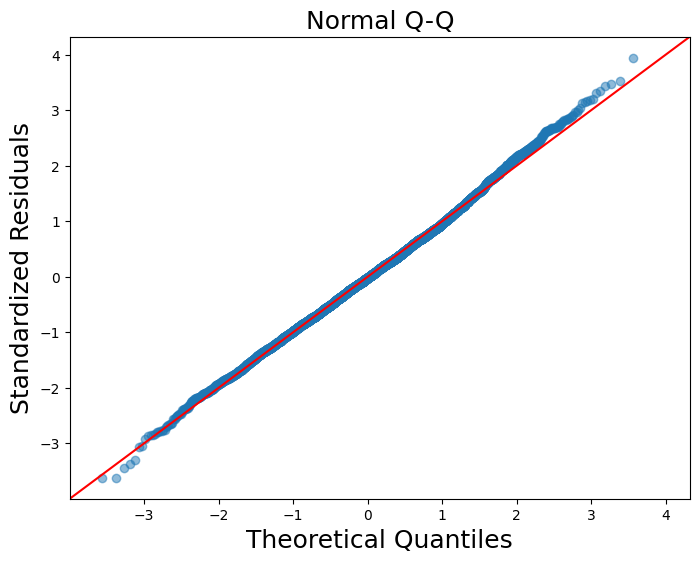

In [85]:
# Obtain normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal

# Create a Q-Q plot
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(ax=ax1, line='45', alpha=0.5, lw=1)

ax1.set_title('Normal Q-Q', fontsize=18)
ax1.set_xlabel('Theoretical Quantiles', fontsize=18)
ax1.set_ylabel('Standardized Residuals', fontsize=18)

# Display the plot
plt.show()

### Residuals vs. Fitted values 
- The main goal of the Residuals vs Fitted Values plot is to detect non-linearity, unequal error variances (heteroscedasticity), and outliers in the data. It's a crucial tool for checking the assumptions underlying linear regression models.
   - The x-axis displays the fitted values (predicted values) from the regression model
   - The y-axis shows the residuals, which are the differences between the observed values and the fitted values.
---
- **WARNING:** 

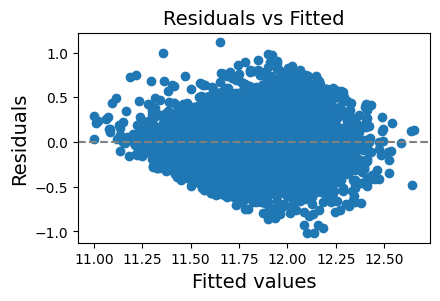

In [86]:
# Calculate residuals and standardized residuals
residuals = results.resid
standardized_residuals = results.get_influence().resid_studentized_internal

# Residuals vs Fitted Values Plot
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.scatter(results.fittedvalues, residuals)
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Fitted', fontsize=14)
plt.show()